In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit,minimize

# Define a mirrored Gaussian function (to model negative GPP)
def mirrored_gaussian(x, a, b, c):
    """
    Mirrored Gaussian function:
    a - amplitude (negative value)
    b - mean (Topt)
    c - standard deviation (spread of the peak)
    """
    return -a * np.exp(-((x - b) ** 2) / (2 * c ** 2))

# Define a fallback cubic polynomial function
def cubic_polynomial(x, a, b, c, d):
    """
    Cubic polynomial function for extrapolation:
    a, b, c, d - polynomial coefficients
    """
    return a * x**3 + b * x**2 + c * x + d

# Function to calculate RMSE
def calculate_rmse(observed, predicted):
    return np.sqrt(np.mean((observed - predicted) ** 2))

# Function to calculate the minimum of a cubic polynomial using optimization
def find_minimum_of_cubic_poly(coeffs, x_range):
    """
    Use optimization to find the minimum of the cubic polynomial.
    """
    # Define the cubic polynomial function
    def poly_func(x):
        a, b, c, d = coeffs
        return a * x**3 + b * x**2 + c * x + d
    
    # Convert x_range to a numpy array and calculate its mean
    x_range_mean = np.mean(np.array(x_range))  # Calculate the mean of the x_range values
    
    # Minimize the cubic polynomial to find the minimum
    result = minimize(poly_func, x_range_mean, bounds=[(min(x_range), max(x_range))])
    return result.x[0]  # Return the x value that minimizes the polynomial


In [8]:

# Define paths and parameters
base_path = "/scratch/c7071034/DATA/Fluxnet2015/Alps/"
plot_path = "/home/c707/c7071034/Github/WRF_VPRM_post/plots/"
site_info = pd.read_csv("/scratch/c7071034/DATA/Fluxnet2015/Alps/site_info_all_FLUXNET2015.csv")
plot_data = False  # Set this to False if you don't want to plot the data
save_data = True  # Set this to False if you don't want to save the data
plot_boxplot = True  # Set this to False if you don't want to plot the boxplot

# Initialize a dictionary to hold min values for each site and year
min_nee_temp_dict = {}
min_nee_temp_dict2 = {}
default_Topt = {
    "ENF": 20.0,  # Evergreen Needleleaf Forest
    "DBF": 20.0,  # Deciduous Needleleaf Forest
    "MF_": 20.0,   # Mixed Forest
    "SHB": 20.0,  # Shrubland
    "SAV": 20.0,  # Savanna
    "CRO": 22.0,  # Cropland
    "GRA": 18.0,  # Grassland
}

# Iterate over all folders in the base path that start with "FLX_"
for folder in os.listdir(base_path):
    if folder.startswith("FLX_"):
        file_base = "_".join(folder.split("_")[0:4])
        years = "_".join(folder.split("_")[4:6])
        file_path = os.path.join(base_path, folder, f"{file_base}_HH_{years}.csv")
        
        # Extract site name
        site_name = folder.split("_")[1]
        # get PFT of site
        i = 0
        for site_i in site_info["site"]:
            if site_name == site_i:
                target_pft = site_info["pft"][i]
                if target_pft == "EBF":
                    target_pft = "DBF"  
                if target_pft == "OSH": # TODO check OSH
                    target_pft = "SHB"
                if site_name == "AT-Mie":
                    target_pft = "ENF"
            i += 1
        site_name = target_pft+"_"+site_name

        # Columns to read and converters
        columns_to_copy = [
            "TIMESTAMP_START",
            "TA_F",
            "NEE_VUT_REF",
            "NIGHT",
        ]
        converters = {k: lambda x: float(x) for k in columns_to_copy}

        # Load the data
        df_site = pd.read_csv(file_path, usecols=columns_to_copy, converters=converters)
        df_site["TIMESTAMP_START"] = pd.to_datetime(df_site["TIMESTAMP_START"], format="%Y%m%d%H%M")
        df_site["PFT"] = target_pft
        # Clean the data
        df_site['TA_F'] = df_site['TA_F'].replace(-9999.0, np.nan)
        df_site = df_site.dropna(subset=['TA_F'])
        df_site['NEE_VUT_REF'] = df_site['NEE_VUT_REF'].replace(-9999.0, np.nan)
        # check how many nan values are in NEE_VUT_REF
        nan_values = df_site['NEE_VUT_REF'].isna()
        nan_sum = nan_values.sum()
        full_year = len(df_site['NEE_VUT_REF'])
        df_site = df_site.dropna(subset=['NEE_VUT_REF'])
        percent_nan = nan_sum.max() / full_year * 100
       
 #  find the name of the column with the most missing values
        if percent_nan > 20:
            print(
                f"WARNING: for {site_name} year {year} is skipped, as {percent_nan:2.1f}% are missing"
            )
            continue

        # Set the values to np.nan during nighttime
        night_columns = ['NEE_VUT_REF']
        df_site.loc[df_site['NIGHT'] == 1, night_columns] = np.nan

        # Convert units from micromol per m² per second to grams of Carbon per day
        #conversion_factor = 12 * 1e-6 * 60 * 60 * 24  # 12 g C per mol, micromol to mol, per second to per day
        #df_site['NEE_VUT_REF'] *= conversion_factor

        # Resample to daily frequency
        df_site.set_index('TIMESTAMP_START', inplace=True)
        df_daily = df_site.resample('D').agg({
            'TA_F': 'mean',
            'NEE_VUT_REF': 'mean'
        }).dropna()

        # Extract the year from the timestamp
        df_daily['YEAR'] = df_daily.index.year

        # List of unique years
        years = df_daily['YEAR'].unique()

        # Initialize site entry in the dictionary
        if site_name not in min_nee_temp_dict:
            min_nee_temp_dict[site_name] = {}
            min_nee_temp_dict2[site_name] = {}

        # Plot for each year and find min NEE temperature
        for year in years:
            # if year == 2012:

            # Filter data for the current year
            df_year = df_daily[df_daily['YEAR'] == year].copy()
            df_year = df_year[df_year['TA_F'] >= 3]

            # Group by each degree of temperature and calculate the mean values
            df_year.loc[:, 'TA_F_rounded'] = df_year['TA_F'].round()
            mean_values = df_year.groupby('TA_F_rounded').mean()

            # Initialize variables
            Topt = np.nan
            fitted_curve = None
            rmse_threshold = 2.0  # Set the RMSE threshold (you can fine-tune this value)

            # First, try to fit the mirrored Gaussian function
            try:
                # Perform Gaussian fit with mirrored curve (negating amplitude)
                popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)
                Topt = popt[1]  # Extract the temperature at the peak of the Gaussian (mean)

                # Generate the fitted curve for plotting or evaluation
                fitted_curve = mirrored_gaussian(mean_values.index, *popt)

                # Calculate RMSE for the Gaussian fit
                rmse = calculate_rmse(mean_values['NEE_VUT_REF'], fitted_curve)
                print(f"RMSE for Gaussian fit: {rmse}")

                if site_name == "ENF_DE-Lbk" and year == 2012:
                    rmse_threshold = 1

                # If RMSE is above threshold, switch to polynomial fit
                if rmse > rmse_threshold:
                    print(f"RMSE exceeds threshold for {year} at Site {site_name}, switching to polynomial fit.")
                    raise RuntimeError("Gaussian fit RMSE too high")

                # Check if Topt is within the observed range
                if Topt < df_year['TA_F_rounded'].max():
                    print(f'Topt is real for {year} at Site {site_name}')
                    real_Topt_col = "green"
                elif Topt > df_year['TA_F_rounded'].max():
                    print(f"Extrapolated Topt is above observed range for {year} at Site {site_name}")
                    real_Topt_col = "yellow"  # Indicate extrapolated Topt
                else:                    
                    Topt = default_Topt.get(site_name.split("_")[0])  # Fallback to default if Topt cant be found
                    real_Topt_col = "red"

            except RuntimeError as e:
                print(f"Gaussian fit failed for {year} at Site {site_name}: {e}")
                # If RMSE threshold exceeded, use the fallback polynomial fit
                print("Using fallback cubic polynomial fit.")
                try:
                    # Perform cubic polynomial fit
                    popt_poly, _ = curve_fit(cubic_polynomial, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)
                    
                    # Find the minimum of the cubic polynomial curve (Topt) using optimization
                    Topt = find_minimum_of_cubic_poly(popt_poly, mean_values.index)

                    # Generate the fitted curve for the cubic polynomial
                    fitted_curve = cubic_polynomial(mean_values.index, *popt_poly)

                    # Extend the range and check if Topt is above the highest temperature
                    if Topt > df_year['TA_F_rounded'].max():
                        print(f"Extrapolated Topt is above observed range for {year} at Site {site_name}")
                        real_Topt_col = "yellow"  # Indicate extrapolated Topt
                    else:
                        real_Topt_col = "green"
                except RuntimeError as e_poly:
                    print(f"Polynomial fit failed for {year} at Site {site_name}: {e_poly}")
                    Topt = default_Topt.get(site_name.split("_")[0])  # Fallback to default if Topt cant be found
                    real_Topt_col = "red"

            # dont use CRO as the cutting events disturb the data too much
            if site_name.startswith("CRO"):
                real_Topt_col = "red"
                print(f"WARNING: for {site_name} year {year} CRO is skipped, as cutting events disturb the data too much")
                Topt = default_Topt.get(site_name.split("_")[0])  # Fallback
            # Store the minimum temperature in the dictionary
            if Topt < 5 or Topt > 30:
                Topt = default_Topt.get(site_name.split("_")[0])  # Fallback to default if Topt cant be found
                real_Topt_col = "red"

            min_nee_temp_dict[site_name][year] = Topt
            min_nee_temp_dict2[site_name][year] = (Topt,real_Topt_col)

            # Visualization
            if plot_data:
                plt.scatter(mean_values.index, mean_values['NEE_VUT_REF'], label='Mean NEE vs. Temperature', color='blue')
                if fitted_curve is not None:
                    plt.plot(mean_values.index, fitted_curve, label='Fitted Curve', color='red')
                if not np.isnan(Topt):
                    plt.axvline(Topt, color=real_Topt_col, linestyle='--', label=f'Topt = {Topt:.2f}')
                plt.xlabel('Temperature (°C)')
                plt.ylabel('NEE_VUT_REF')
                plt.legend()
                plt.title(f'Optimal Temperature (Topt) for {site_name} in {year}')
                plt.savefig(
                            os.path.join(plot_path, "optimum_temp_"+site_name+"_"+str(year)+".pdf"),
                            dpi=300,
                            bbox_inches="tight",
                        )
                # plt.show()
                plt.clf()
                                


RMSE for Gaussian fit: 0.7646269032172813
Extrapolated Topt is above observed range for 2008 at Site GRA_IT-Tor
RMSE for Gaussian fit: 0.7486525686380886
Topt is real for 2009 at Site GRA_IT-Tor
RMSE for Gaussian fit: 1.1372724547802997
Topt is real for 2010 at Site GRA_IT-Tor
RMSE for Gaussian fit: 0.8365927330023604
Topt is real for 2011 at Site GRA_IT-Tor
RMSE for Gaussian fit: 0.7281702074027493
Topt is real for 2012 at Site GRA_IT-Tor
RMSE for Gaussian fit: 0.7074592329836495
Topt is real for 2013 at Site GRA_IT-Tor
RMSE for Gaussian fit: 0.6836391411699057
Topt is real for 2014 at Site GRA_IT-Tor
RMSE for Gaussian fit: 1.9961536913313418
Topt is real for 2004 at Site CRO_FR-Gri
RMSE for Gaussian fit: 6.470617248908681
RMSE exceeds threshold for 2005 at Site CRO_FR-Gri, switching to polynomial fit.
Gaussian fit failed for 2005 at Site CRO_FR-Gri: Gaussian fit RMSE too high
Using fallback cubic polynomial fit.
RMSE for Gaussian fit: 1.4454245200229017
Topt is real for 2006 at Site 

/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)
/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)


RMSE for Gaussian fit: 7.0353172560885735
RMSE exceeds threshold for 2013 at Site DBF_IT-Isp, switching to polynomial fit.
Gaussian fit failed for 2013 at Site DBF_IT-Isp: Gaussian fit RMSE too high
Using fallback cubic polynomial fit.
RMSE for Gaussian fit: 6.0049898153243095
RMSE exceeds threshold for 2014 at Site DBF_IT-Isp, switching to polynomial fit.
Gaussian fit failed for 2014 at Site DBF_IT-Isp: Gaussian fit RMSE too high
Using fallback cubic polynomial fit.
RMSE for Gaussian fit: 1.2423651138174792
Topt is real for 2004 at Site MF_CH-Lae
RMSE for Gaussian fit: 1.4073767064726208
Topt is real for 2005 at Site MF_CH-Lae
RMSE for Gaussian fit: 0.7048389146066302
Topt is real for 2006 at Site MF_CH-Lae
RMSE for Gaussian fit: 1.2960573769197707
Topt is real for 2007 at Site MF_CH-Lae
RMSE for Gaussian fit: 7.924239769560829
RMSE exceeds threshold for 2008 at Site MF_CH-Lae, switching to polynomial fit.
Gaussian fit failed for 2008 at Site MF_CH-Lae: Gaussian fit RMSE too high
Usin

/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)


RMSE for Gaussian fit: 1.192630945219353
Topt is real for 2009 at Site MF_CH-Lae
RMSE for Gaussian fit: 1.328028077648627
Topt is real for 2010 at Site MF_CH-Lae
RMSE for Gaussian fit: 1.0396919800904625
Topt is real for 2011 at Site MF_CH-Lae
RMSE for Gaussian fit: 1.2517283117932119
Topt is real for 2012 at Site MF_CH-Lae
RMSE for Gaussian fit: 1.7115130840621564
Topt is real for 2013 at Site MF_CH-Lae
RMSE for Gaussian fit: 1.0990894890518843
Topt is real for 2014 at Site MF_CH-Lae
RMSE for Gaussian fit: 1.819777031140684
Topt is real for 2000 at Site ENF_IT-La2
RMSE for Gaussian fit: 1.0036177750102921
Topt is real for 2001 at Site ENF_IT-La2
RMSE for Gaussian fit: 0.43278021479953277
Topt is real for 2002 at Site ENF_IT-La2
RMSE for Gaussian fit: 0.33011094120676543
Topt is real for 1997 at Site ENF_CH-Dav
RMSE for Gaussian fit: 0.49294082424501917
Topt is real for 1998 at Site ENF_CH-Dav
RMSE for Gaussian fit: 0.625018061202085
Topt is real for 1999 at Site ENF_CH-Dav
RMSE for Ga

/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)
/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)


RMSE for Gaussian fit: 2.1412660837995383
RMSE exceeds threshold for 2005 at Site GRA_CH-Cha, switching to polynomial fit.
Gaussian fit failed for 2005 at Site GRA_CH-Cha: Gaussian fit RMSE too high
Using fallback cubic polynomial fit.
RMSE for Gaussian fit: 1.7039688398502542
Topt is real for 2006 at Site GRA_CH-Cha
Gaussian fit failed for 2007 at Site GRA_CH-Cha: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Using fallback cubic polynomial fit.
RMSE for Gaussian fit: 1.8713771884484651
Topt is real for 2008 at Site GRA_CH-Cha
RMSE for Gaussian fit: 1.1535863597671554
Extrapolated Topt is above observed range for 2009 at Site GRA_CH-Cha
RMSE for Gaussian fit: 1.5933786037658944
Topt is real for 2010 at Site GRA_CH-Cha
RMSE for Gaussian fit: 1.9449953849595982
Topt is real for 2011 at Site GRA_CH-Cha
Gaussian fit failed for 2012 at Site GRA_CH-Cha: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Using fallbac

/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)
/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)


RMSE for Gaussian fit: 0.40265200185646693
Topt is real for 2011 at Site ENF_DE-Lkb
RMSE for Gaussian fit: 1.5204608280293728
Extrapolated Topt is above observed range for 2012 at Site ENF_DE-Lkb
RMSE for Gaussian fit: 0.3994565274419267
Topt is real for 2013 at Site ENF_DE-Lkb


/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)
/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)
/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)


RMSE for Gaussian fit: 7.104515682490481
RMSE exceeds threshold for 2005 at Site DBF_FR-Fon, switching to polynomial fit.
Gaussian fit failed for 2005 at Site DBF_FR-Fon: Gaussian fit RMSE too high
Using fallback cubic polynomial fit.
RMSE for Gaussian fit: 6.539077179012145
RMSE exceeds threshold for 2006 at Site DBF_FR-Fon, switching to polynomial fit.
Gaussian fit failed for 2006 at Site DBF_FR-Fon: Gaussian fit RMSE too high
Using fallback cubic polynomial fit.
RMSE for Gaussian fit: 7.356091944788609
RMSE exceeds threshold for 2007 at Site DBF_FR-Fon, switching to polynomial fit.
Gaussian fit failed for 2007 at Site DBF_FR-Fon: Gaussian fit RMSE too high
Using fallback cubic polynomial fit.
RMSE for Gaussian fit: 1.3848936343277327
Topt is real for 2008 at Site DBF_FR-Fon
RMSE for Gaussian fit: 7.59555898963729
RMSE exceeds threshold for 2009 at Site DBF_FR-Fon, switching to polynomial fit.
Gaussian fit failed for 2009 at Site DBF_FR-Fon: Gaussian fit RMSE too high
Using fallback 

/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)
/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)


RMSE for Gaussian fit: 6.8386111039213064
RMSE exceeds threshold for 2012 at Site DBF_FR-Fon, switching to polynomial fit.
Gaussian fit failed for 2012 at Site DBF_FR-Fon: Gaussian fit RMSE too high
Using fallback cubic polynomial fit.
RMSE for Gaussian fit: 1.1713431211682384
Topt is real for 2013 at Site DBF_FR-Fon
RMSE for Gaussian fit: 6.904069975432246
RMSE exceeds threshold for 2014 at Site DBF_FR-Fon, switching to polynomial fit.
Gaussian fit failed for 2014 at Site DBF_FR-Fon: Gaussian fit RMSE too high
Using fallback cubic polynomial fit.
RMSE for Gaussian fit: 2.131138876936635
RMSE exceeds threshold for 2004 at Site CRO_DE-Kli, switching to polynomial fit.
Gaussian fit failed for 2004 at Site CRO_DE-Kli: Gaussian fit RMSE too high
Using fallback cubic polynomial fit.
RMSE for Gaussian fit: 3.047096791100153
RMSE exceeds threshold for 2005 at Site CRO_DE-Kli, switching to polynomial fit.
Gaussian fit failed for 2005 at Site CRO_DE-Kli: Gaussian fit RMSE too high
Using fallbac

/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)
/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)
/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)


RMSE for Gaussian fit: 1.6494935692909676
Topt is real for 2010 at Site CRO_DE-Kli
RMSE for Gaussian fit: 1.7462936767276929
Topt is real for 2011 at Site CRO_DE-Kli
RMSE for Gaussian fit: 2.4774464258684716
RMSE exceeds threshold for 2012 at Site CRO_DE-Kli, switching to polynomial fit.
Gaussian fit failed for 2012 at Site CRO_DE-Kli: Gaussian fit RMSE too high
Using fallback cubic polynomial fit.
RMSE for Gaussian fit: 1.0227232689390369
Topt is real for 2013 at Site CRO_DE-Kli
RMSE for Gaussian fit: 3.475827479567542
RMSE exceeds threshold for 2014 at Site CRO_DE-Kli, switching to polynomial fit.
Gaussian fit failed for 2014 at Site CRO_DE-Kli: Gaussian fit RMSE too high
Using fallback cubic polynomial fit.


/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)
/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)
/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)
/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)
/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, m

RMSE for Gaussian fit: 9.203246952225053
RMSE exceeds threshold for 2000 at Site DBF_DE-Hai, switching to polynomial fit.
Gaussian fit failed for 2000 at Site DBF_DE-Hai: Gaussian fit RMSE too high
Using fallback cubic polynomial fit.
RMSE for Gaussian fit: 10.135142767753745
RMSE exceeds threshold for 2001 at Site DBF_DE-Hai, switching to polynomial fit.
Gaussian fit failed for 2001 at Site DBF_DE-Hai: Gaussian fit RMSE too high
Using fallback cubic polynomial fit.
RMSE for Gaussian fit: 10.664519379079497
RMSE exceeds threshold for 2002 at Site DBF_DE-Hai, switching to polynomial fit.
Gaussian fit failed for 2002 at Site DBF_DE-Hai: Gaussian fit RMSE too high
Using fallback cubic polynomial fit.
RMSE for Gaussian fit: 7.382367566685775
RMSE exceeds threshold for 2003 at Site DBF_DE-Hai, switching to polynomial fit.
Gaussian fit failed for 2003 at Site DBF_DE-Hai: Gaussian fit RMSE too high
Using fallback cubic polynomial fit.
RMSE for Gaussian fit: 7.871520960773897
RMSE exceeds thre

/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)
/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)
/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)
/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)
/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, m

RMSE for Gaussian fit: 8.354155729270689
RMSE exceeds threshold for 2006 at Site DBF_DE-Hai, switching to polynomial fit.
Gaussian fit failed for 2006 at Site DBF_DE-Hai: Gaussian fit RMSE too high
Using fallback cubic polynomial fit.
RMSE for Gaussian fit: 8.517249316165724
RMSE exceeds threshold for 2007 at Site DBF_DE-Hai, switching to polynomial fit.
Gaussian fit failed for 2007 at Site DBF_DE-Hai: Gaussian fit RMSE too high
Using fallback cubic polynomial fit.
RMSE for Gaussian fit: 8.375512489260379
RMSE exceeds threshold for 2008 at Site DBF_DE-Hai, switching to polynomial fit.
Gaussian fit failed for 2008 at Site DBF_DE-Hai: Gaussian fit RMSE too high
Using fallback cubic polynomial fit.
RMSE for Gaussian fit: 8.39030948307844
RMSE exceeds threshold for 2009 at Site DBF_DE-Hai, switching to polynomial fit.
Gaussian fit failed for 2009 at Site DBF_DE-Hai: Gaussian fit RMSE too high
Using fallback cubic polynomial fit.
RMSE for Gaussian fit: 8.507416279658969
RMSE exceeds thresho

/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)


RMSE for Gaussian fit: 1.074279135178668
Topt is real for 2003 at Site ENF_IT-Lav
RMSE for Gaussian fit: 1.0528368437133961
Topt is real for 2004 at Site ENF_IT-Lav
RMSE for Gaussian fit: 0.9445105876439571
Topt is real for 2005 at Site ENF_IT-Lav
RMSE for Gaussian fit: 0.8503610799105488
Topt is real for 2006 at Site ENF_IT-Lav
RMSE for Gaussian fit: 0.8805616010336319
Topt is real for 2007 at Site ENF_IT-Lav
RMSE for Gaussian fit: 1.0056233638759011
Topt is real for 2008 at Site ENF_IT-Lav
RMSE for Gaussian fit: 1.7900866455458078
Topt is real for 2009 at Site ENF_IT-Lav
RMSE for Gaussian fit: 0.8153889280196746
Topt is real for 2010 at Site ENF_IT-Lav
RMSE for Gaussian fit: 0.8345208464023032
Topt is real for 2011 at Site ENF_IT-Lav
RMSE for Gaussian fit: 0.9537945241222772
Topt is real for 2012 at Site ENF_IT-Lav
RMSE for Gaussian fit: 0.7880196307155365
Topt is real for 2013 at Site ENF_IT-Lav
RMSE for Gaussian fit: 1.2663183105131588
Topt is real for 2014 at Site ENF_IT-Lav
RMSE 

/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)
/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)


RMSE for Gaussian fit: 1.5981927471580821
Topt is real for 2005 at Site GRA_AT-Neu
RMSE for Gaussian fit: 1.8819809495223419
Topt is real for 2006 at Site GRA_AT-Neu
RMSE for Gaussian fit: 2.9353131568681734
RMSE exceeds threshold for 2007 at Site GRA_AT-Neu, switching to polynomial fit.
Gaussian fit failed for 2007 at Site GRA_AT-Neu: Gaussian fit RMSE too high
Using fallback cubic polynomial fit.
RMSE for Gaussian fit: 2.1989043141048747
RMSE exceeds threshold for 2008 at Site GRA_AT-Neu, switching to polynomial fit.
Gaussian fit failed for 2008 at Site GRA_AT-Neu: Gaussian fit RMSE too high
Using fallback cubic polynomial fit.
RMSE for Gaussian fit: 1.6607639214216479
Topt is real for 2009 at Site GRA_AT-Neu
RMSE for Gaussian fit: 1.823586583845557
Topt is real for 2010 at Site GRA_AT-Neu
RMSE for Gaussian fit: 1.4774695075072877
Topt is real for 2011 at Site GRA_AT-Neu
RMSE for Gaussian fit: 1.397273343506306
Topt is real for 2012 at Site GRA_AT-Neu
Gaussian fit failed for 2005 at 

/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)


RMSE for Gaussian fit: 4.192446174080351
RMSE exceeds threshold for 2004 at Site CRO_CH-Oe2, switching to polynomial fit.
Gaussian fit failed for 2004 at Site CRO_CH-Oe2: Gaussian fit RMSE too high
Using fallback cubic polynomial fit.
RMSE for Gaussian fit: 1.7421411189019949
Topt is real for 2005 at Site CRO_CH-Oe2
RMSE for Gaussian fit: 0.9060194032252012
Topt is real for 2006 at Site CRO_CH-Oe2
RMSE for Gaussian fit: 1.8934251433791163
Topt is real for 2007 at Site CRO_CH-Oe2
RMSE for Gaussian fit: 1.2851438776354849
Topt is real for 2008 at Site CRO_CH-Oe2
RMSE for Gaussian fit: 2.003437951664112
RMSE exceeds threshold for 2009 at Site CRO_CH-Oe2, switching to polynomial fit.
Gaussian fit failed for 2009 at Site CRO_CH-Oe2: Gaussian fit RMSE too high
Using fallback cubic polynomial fit.
Gaussian fit failed for 2010 at Site CRO_CH-Oe2: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Using fallback cubic polynomial fit.
RMSE for Gaussian fit: 1.4

/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)


RMSE for Gaussian fit: 0.9588745142370623
Topt is real for 2003 at Site GRA_IT-MBo
RMSE for Gaussian fit: 5.123997824776025
RMSE exceeds threshold for 2004 at Site GRA_IT-MBo, switching to polynomial fit.
Gaussian fit failed for 2004 at Site GRA_IT-MBo: Gaussian fit RMSE too high
Using fallback cubic polynomial fit.
RMSE for Gaussian fit: 0.965686326768245
Topt is real for 2005 at Site GRA_IT-MBo


/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)


RMSE for Gaussian fit: 1.2552638062825368
Topt is real for 2006 at Site GRA_IT-MBo
RMSE for Gaussian fit: 0.9259624781805821
Topt is real for 2007 at Site GRA_IT-MBo
RMSE for Gaussian fit: 1.663234475894651
Extrapolated Topt is above observed range for 2008 at Site GRA_IT-MBo
RMSE for Gaussian fit: 4.749324465660595
RMSE exceeds threshold for 2009 at Site GRA_IT-MBo, switching to polynomial fit.
Gaussian fit failed for 2009 at Site GRA_IT-MBo: Gaussian fit RMSE too high
Using fallback cubic polynomial fit.
RMSE for Gaussian fit: 0.7441605993334658
Topt is real for 2010 at Site GRA_IT-MBo


/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)


RMSE for Gaussian fit: 1.0306057153396775
Topt is real for 2011 at Site GRA_IT-MBo
RMSE for Gaussian fit: 0.6981263875139083
Topt is real for 2012 at Site GRA_IT-MBo
RMSE for Gaussian fit: 4.651422925822401
RMSE exceeds threshold for 2013 at Site GRA_IT-MBo, switching to polynomial fit.
Gaussian fit failed for 2013 at Site GRA_IT-MBo: Gaussian fit RMSE too high
Using fallback cubic polynomial fit.


/tmp/ipykernel_4061146/489407117.py:122: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(mirrored_gaussian, mean_values.index, mean_values['NEE_VUT_REF'], maxfev=10000)


In [9]:
# Filter the dictionary to exclude entries where real_Topt_col is "red"
filtered_dict = {
    site: {
        year: Topt
        for year, (Topt, color) in year_data.items()
        if color != "red"
    }
    for site, year_data in min_nee_temp_dict2.items()
}

# Convert the filtered dictionary to a DataFrame
filtered_df = pd.DataFrame(filtered_dict).T

# Sort the DataFrame by site and year
filtered_df = filtered_df.sort_index(axis=0, ascending=True)

# Optionally save the filtered DataFrame to a CSV file
if save_data:
    filtered_df.to_csv(os.path.join(plot_path, 'filtered_Topt_values.csv'))

# Display the filtered DataFrame
print(filtered_df)


                 2008       2009       2010       2011       2012       2013  \
CRO_CH-Oe2        NaN        NaN        NaN        NaN        NaN        NaN   
CRO_DE-Kli        NaN        NaN        NaN        NaN        NaN        NaN   
CRO_FR-Gri        NaN        NaN        NaN        NaN        NaN        NaN   
DBF_DE-Hai  19.197496  20.861173  21.553056  18.227252  24.025376        NaN   
DBF_FR-Fon  19.856875  20.251069  21.177621  20.776437  21.760981  22.271565   
DBF_IT-Isp        NaN        NaN        NaN        NaN        NaN  25.521920   
DBF_IT-PT1        NaN        NaN        NaN        NaN        NaN        NaN   
ENF_CH-Dav   9.463438   8.439146   8.136247   9.695428  11.599889   7.867194   
ENF_DE-Lkb        NaN  20.876090        NaN  19.274004        NaN  18.351184   
ENF_IT-La2        NaN        NaN        NaN        NaN        NaN        NaN   
ENF_IT-Lav  13.269231  13.994634  13.926856  14.524282  14.545531  14.119685   
ENF_IT-Ren  11.745865  12.446353  10.992

In [10]:

counts = {}
for site, years in min_nee_temp_dict2.items():
    vals = [val[0] for val in years.values()]  # take first element of tuple
    non_nan_count = sum(isinstance(v, float) and not np.isnan(v) for v in vals)
    counts[site] = non_nan_count

print(counts)
# print sum of all counts
print("Total number of valid Topt entries:", sum(counts.values()))

{'GRA_IT-Tor': 7, 'CRO_FR-Gri': 11, 'DBF_IT-Isp': 2, 'MF_CH-Lae': 11, 'ENF_IT-La2': 3, 'ENF_CH-Dav': 18, 'ENF_IT-Ren': 15, 'DBF_IT-PT1': 3, 'GRA_CH-Cha': 10, 'ENF_DE-Lkb': 5, 'DBF_FR-Fon': 10, 'CRO_DE-Kli': 11, 'DBF_DE-Hai': 13, 'ENF_IT-Lav': 12, 'GRA_AT-Neu': 11, 'GRA_CH-Fru': 10, 'CRO_CH-Oe2': 11, 'GRA_CH-Oe1': 7, 'GRA_IT-MBo': 11}
Total number of valid Topt entries: 181


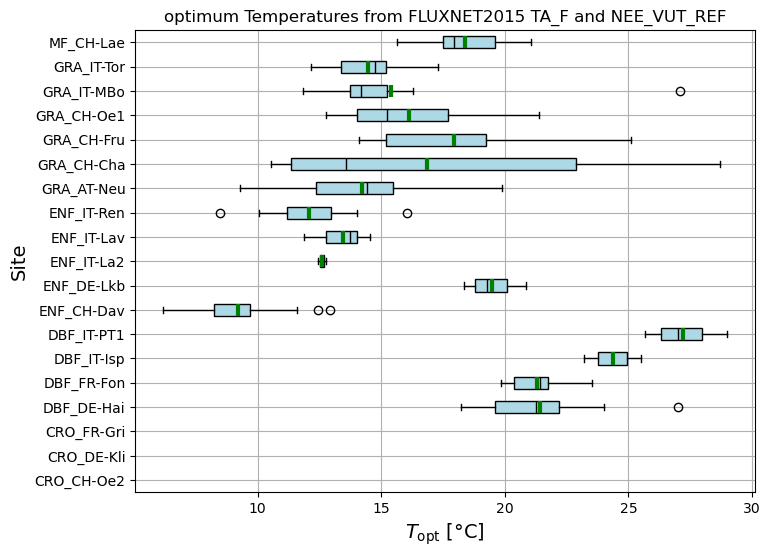

In [16]:
if plot_boxplot:
    min_nee_temp_df_long = filtered_df.reset_index().melt(
        id_vars='index', var_name='Year', value_name='Temperature'
    )
    min_nee_temp_df_long.rename(columns={'index': 'Site'}, inplace=True)
    # Ensure Year is string for safe concatenation/labeling
    min_nee_temp_df_long['Year'] = min_nee_temp_df_long['Year'].astype(str)


    font_size = 12
    plt.figure(figsize=(8, 6))

    # Collect unique sites and data
    sites = min_nee_temp_df_long["Site"].unique()
    data = [
        min_nee_temp_df_long.loc[min_nee_temp_df_long["Site"] == site, "Temperature"].dropna().values
        for site in sites
    ]

    # Boxplot with mean line
    plt.boxplot(
        data,
        vert=False,
        patch_artist=True,
        showmeans=True,
        meanline=True,
        boxprops=dict(facecolor="lightblue", color="black"),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        medianprops=dict(color="black"),   # median black
        meanprops=dict(color="green", linestyle="-", linewidth=3),  # dashed mean
    )

    # Align y-ticks with site names
    plt.yticks(range(1, len(sites) + 1), sites)

    plt.xlabel(r'$T_{\mathrm{opt}}$ [°C]',fontsize=font_size+2)
    plt.ylabel('Site',fontsize=font_size+2)
    plt.title('optimum Temperatures from FLUXNET2015 TA_F and NEE_VUT_REF',fontsize=font_size)
    plt.suptitle('')  # Remove the default 'Boxplot grouped by Site' title
    plt.grid(True)

    # Save the plot to an EPS file
    plt.savefig(
        os.path.join(plot_path, "boxplot_Topt_Alps.pdf"),
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()



In [ ]:
# mean_nee_temp_df = min_nee_temp_df_long.mean(axis=1)
# pft = mean_nee_temp_df.index.str[:3]
# df = pd.DataFrame({'PFT': pft, 'mean_temp': mean_nee_temp_df.values})
# mean_temp_by_pft = df.groupby('PFT')['mean_temp'].mean().reset_index()

# print(mean_temp_by_pft)

TypeError: can only concatenate str (not "int") to str